In [1]:
import ibmos2spark
from pyspark.sql.functions import count,countDistinct
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
spark = SparkSession.builder.getOrCreate()
plt.style.use('ggplot')

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': 'Mah02bEi7GKj9hczaiL-NL7wB1ZrY7LfQx-6-TpVvu3W',
    'service_id': 'iam-ServiceId-b028ce9d-a803-48bc-bdc5-d57d88989644',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token'}

configuration_name = 'os_9e785eb379d44200ba4fa10da519fc98_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')


df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option("inferSchema", "true")\
  .load(cos.url('AZFI_APPRX_Product_Processed.csv', 'amazonreviews-donotdelete-pr-qdqutmdfrupodw'))
df.take(5)

[Row(experimentNum=1, runtime=81.081130027771, thread=1, emitNum=1, estimate=1481, item='0007205236', lowerBound=1405, upperBound=1481, mapSize=128),
 Row(experimentNum=1, runtime=81.081130027771, thread=1, emitNum=1, estimate=400, item='0028627717', lowerBound=324, upperBound=400, mapSize=128),
 Row(experimentNum=1, runtime=81.081130027771, thread=1, emitNum=1, estimate=366, item='0007183518', lowerBound=290, upperBound=366, mapSize=128),
 Row(experimentNum=1, runtime=81.081130027771, thread=1, emitNum=1, estimate=330, item='003061368X', lowerBound=254, upperBound=330, mapSize=128),
 Row(experimentNum=1, runtime=81.081130027771, thread=1, emitNum=1, estimate=307, item='0007447094', lowerBound=231, upperBound=307, mapSize=128)]

In [2]:
schema = StructType([
    StructField("user", StringType(), True),
    StructField("product", StringType(), True),
    StructField("rating", DoubleType(), True),
    StructField("timestamp", IntegerType(), True)])
exact_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .schema(schema)\
  .load(cos.url('ratings.csv', 'amazonreviews-donotdelete-pr-qdqutmdfrupodw'))
exact_data.take(5)

[Row(user='AH2L9G3DQHHAJ', product='0000000116', rating=4.0, timestamp=1019865600),
 Row(user='A2IIIDRK3PRRZY', product='0000000116', rating=1.0, timestamp=1395619200),
 Row(user='A1TADCM7YWPQ8M', product='0000000868', rating=4.0, timestamp=1031702400),
 Row(user='AWGH7V0BDOJKB', product='0000013714', rating=4.0, timestamp=1383177600),
 Row(user='A3UTQPQPM4TQO0', product='0000013714', rating=5.0, timestamp=1374883200)]

In [3]:
df.createOrReplaceTempView("results")
max_emit_num = spark.sql("SELECT item,MAX(emitNum) as emitNum FROM results GROUP BY item")
gr = exact_data.groupBy("product").agg(count("product").alias('count')).orderBy('count',ascending=False)
gr.show()

+----------+-----+
|   product|count|
+----------+-----+
|B0054JZC6E|25368|
|B00FAPF5U0|24024|
|B009UX2YAC|23956|
|0439023483|21398|
|030758836X|19867|
|B0051VVOB2|19529|
|B005SUHPO6|18688|
|B00G5LQ5MU|18645|
|B0074BW614|18244|
|B000GF7ZRA|17948|
|B00DR0PDNE|16454|
|B0064X7B4A|16239|
|B00DJFIMW6|16221|
|B00I8Q77Y0|15601|
|B00992CF6W|15294|
|B00AREIAI8|15080|
|B00AWH595M|14393|
|B005ZXWMUS|14310|
|B007WTAJTO|14172|
|0439023513|14114|
+----------+-----+
only showing top 20 rows



In [4]:
counts_desc = gr.select('count').orderBy('count',ascending=False)
counts_asc = gr.select('count').orderBy('count',ascending=True)

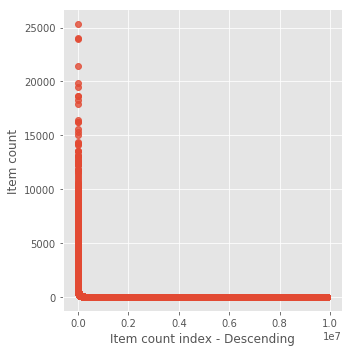

In [5]:
ax = sns.lmplot( x="index", y="count", data=counts_desc.toPandas().reset_index(), fit_reg=False)
plt.xlabel('Item count index - Descending')
# Set y-axis label
plt.ylabel('Item count')
plt.show()

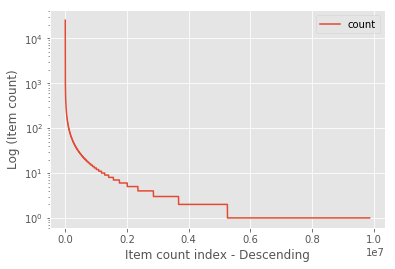

In [6]:
ax = counts_desc.toPandas().plot(logy=True, logx=False)
plt.xlabel('Item count index - Descending')
# Set y-axis label
plt.ylabel('Log (Item count)')
plt.show()

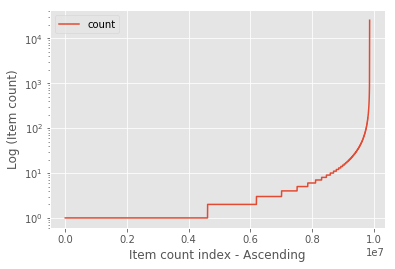

In [7]:
ax = counts_asc.toPandas().plot(logy=True, logx=False)
plt.xlabel('Item count index - Ascending')
# Set y-axis label
plt.ylabel('Log (Item count)')
plt.show()

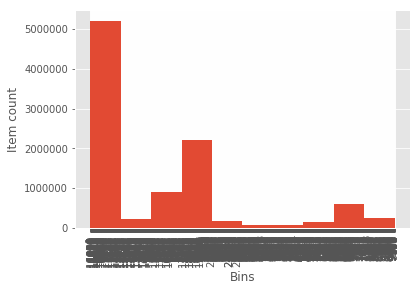

In [8]:
ax = plt.hist(counts_asc.toPandas(), bins=10)
plt.xticks(rotation=90)
plt.xlabel('Bins')
plt.ylabel('Item count')
plt.show()

In [9]:
distinct_keys = exact_data.agg(countDistinct("product"))
distinct_keys.show()

+-----------------------+
|count(DISTINCT product)|
+-----------------------+
|                9874210|
+-----------------------+



/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


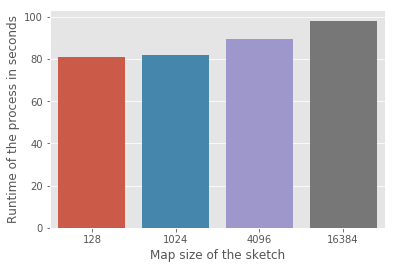

In [10]:
runtime = df.select('mapSize','runtime').distinct()
df_runtime = runtime.toPandas()
ax = sns.barplot( x="mapSize", y="runtime", data=df_runtime)
plt.xlabel('Map size of the sketch')
# Set y-axis label
plt.ylabel('Runtime of the process in seconds')
plt.show()

In [11]:
experiment1 = df.filter(df['experimentNum'] == 1)
experiment1.createOrReplaceTempView("experiment1")
experiment1 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment1 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment1 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare1 = experiment1.join(gr, experiment1.item == gr.product)
df_compare1.createOrReplaceTempView("df_compare1")
diff1 = spark.sql('SELECT mapSize,item,estimate,lowerBound,upperBound,count, estimate - count as diff, round((100.0*ABS(estimate - count)) / count,3)as diff_percent ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare1 ORDER BY count DESC')
diff1.show()


+-------+----------+--------+----------+----------+-----+----+------------+---------+---------+
|mapSize|      item|estimate|lowerBound|upperBound|count|diff|diff_percent|diffLower|diffUpper|
+-------+----------+--------+----------+----------+-----+----+------------+---------+---------+
|    128|0439023483|   28208|     14119|     28208|21398|6810|      31.825|    -7279|     6810|
|    128|030758836X|   22701|     11365|     22701|19867|2834|      14.265|    -8502|     2834|
|    128|0439023513|   21067|     10683|     21067|14114|6953|      49.263|    -3431|     6953|
|    128|0385537859|   19279|      9789|     19279|12973|6306|      48.609|    -3184|     6306|
|    128|0007444117|   12647|      6327|     12647|12629|  18|       0.143|    -6302|       18|
|    128|0375831002|   17645|      8914|     17645|12571|5074|      40.363|    -3657|     5074|
|    128|038536315X|   17543|      8832|     17543|12564|4979|      39.629|    -3732|     4979|
|    128|0345803485|   17438|      8791|

In [12]:
diff1.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+-----------------+--------------------+------------------+-----------------+
|summary|             diff|        diff_percent|         diffLower|        diffUpper|
+-------+-----------------+--------------------+------------------+-----------------+
|  count|              485|                 485|               485|              485|
|   mean|565.4247422680412|34.09612164948453...|-355.2907216494845|565.4247422680412|
| stddev|1109.957729914284|  27.485746236726346| 856.4242161648456|1109.957729914284|
|    min|                0|               0.000|             -8502|                0|
|    max|             6953|              99.579|                 0|             6953|
+-------+-----------------+--------------------+------------------+-----------------+



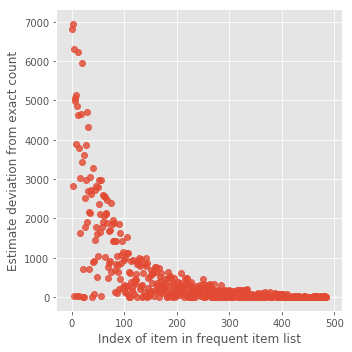

In [13]:
pd_diff1 = diff1.toPandas()
pd_diff1['s_index'] = range(1, len(pd_diff1) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff1, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

In [14]:
experiment2 = df.filter(df['experimentNum'] == 2)
experiment2.createOrReplaceTempView("experiment2")
experiment2 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment2 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment2 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare2 = experiment2.join(gr, experiment2.item == gr.product)
df_compare2.createOrReplaceTempView("df_compare2")
diff2 = spark.sql('SELECT mapSize,item,estimate,lowerBound,upperBound,count, estimate - count as diff, round((100.0*ABS(estimate - count)) / count,3)as diff_percent ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare2 ORDER BY count DESC')
diff2.show()

+-------+----------+--------+----------+----------+-----+-----+------------+---------+---------+
|mapSize|      item|estimate|lowerBound|upperBound|count| diff|diff_percent|diffLower|diffUpper|
+-------+----------+--------+----------+----------+-----+-----+------------+---------+---------+
|   1024|B0054JZC6E|   34988|     21305|     34988|25368| 9620|      37.922|    -4063|     9620|
|   1024|B00FAPF5U0|   36897|     23518|     36897|24024|12873|      53.584|     -506|    12873|
|   1024|B009UX2YAC|   35701|     22101|     35701|23956|11745|      49.027|    -1855|    11745|
|   1024|0439023483|   22066|     11058|     22066|21398|  668|       3.122|   -10340|      668|
|   1024|030758836X|   20113|     10067|     20113|19867|  246|       1.238|    -9800|      246|
|   1024|B0051VVOB2|   28993|     15393|     28993|19529| 9464|      48.461|    -4136|     9464|
|   1024|B005SUHPO6|   27733|     15413|     27733|18688| 9045|      48.400|    -3275|     9045|
|   1024|B00G5LQ5MU|   31834| 

In [15]:
diff2.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+-----------------+--------------------+------------------+-----------------+
|summary|             diff|        diff_percent|         diffLower|        diffUpper|
+-------+-----------------+--------------------+------------------+-----------------+
|  count|            15255|               15255|             15255|            15255|
|   mean|95.50835791543756|29.26369190429367...|-67.10770239265814|95.50835791543756|
| stddev|593.9941448355222|  30.179093708379128| 310.1792957188721|593.9941448355222|
|    min|                0|               0.000|            -10340|                0|
|    max|            13565|             100.000|                 0|            13565|
+-------+-----------------+--------------------+------------------+-----------------+



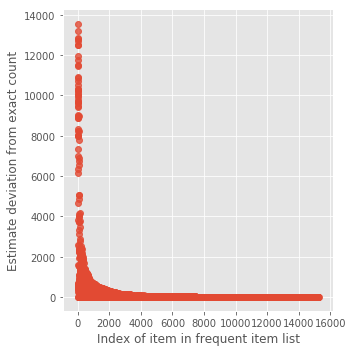

In [16]:
pd_diff2 = diff2.toPandas()
pd_diff2['s_index'] = range(1, len(pd_diff2) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff2, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

In [17]:
pd_diff2

,mapSize,item,estimate,lowerBound,upperBound,count,diff,diff_percent,diffLower,diffUpper,s_index
0,1024,B0054JZC6E,34988,21305,34988,25368,9620,37.922,-4063,9620,1
1,1024,B00FAPF5U0,36897,23518,36897,24024,12873,53.584,-506,12873,2
2,1024,B009UX2YAC,35701,22101,35701,23956,11745,49.027,-1855,11745,3
3,1024,0439023483,22066,11058,22066,21398,668,3.122,-10340,668,4
4,1024,030758836X,20113,10067,20113,19867,246,1.238,-9800,246,5
5,1024,B0051VVOB2,28993,15393,28993,19529,9464,48.461,-4136,9464,6
6,1024,B005SUHPO6,27733,15413,27733,18688,9045,48.400,-3275,9045,7
7,1024,B00G5LQ5MU,31834,18234,31834,18645,13189,70.737,-411,13189,8
8,1024,B0074BW614,27681,15489,27681,18244,9437,51.727,-2755,9437,9
9,1024,B000GF7ZRA,22620,11311,22620,17948,4672,26.031,-6637,4672,10


In [18]:
experiment3 = df.filter(df['experimentNum'] == 3)
experiment3.createOrReplaceTempView("experiment3")
experiment3 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment3 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment3 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare3 = experiment3.join(gr, experiment3.item == gr.product)
df_compare3.createOrReplaceTempView("df_compare3")
diff3 = spark.sql('SELECT mapSize,item,estimate,lowerBound,upperBound,count, estimate - count as diff, round((100.0*ABS(estimate - count)) / count,3)as diff_percent ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare3 ORDER BY count DESC')
diff3.show()

+-------+----------+--------+----------+----------+-----+----+------------+---------+---------+
|mapSize|      item|estimate|lowerBound|upperBound|count|diff|diff_percent|diffLower|diffUpper|
+-------+----------+--------+----------+----------+-----+----+------------+---------+---------+
|   4096|B0054JZC6E|   27659|     24373|     27659|25368|2291|       9.031|     -995|     2291|
|   4096|B00FAPF5U0|   27152|     23899|     27152|24024|3128|      13.020|     -125|     3128|
|   4096|B009UX2YAC|   26730|     23509|     26730|23956|2774|      11.580|     -447|     2774|
|   4096|0439023483|   21505|     18558|     21505|21398| 107|       0.500|    -2840|      107|
|   4096|030758836X|   19901|     16954|     19901|19867|  34|       0.171|    -2913|       34|
|   4096|B0051VVOB2|   21762|     18541|     21762|19529|2233|      11.434|     -988|     2233|
|   4096|B005SUHPO6|   20842|     17893|     20842|18688|2154|      11.526|     -795|     2154|
|   4096|B00G5LQ5MU|   21765|     18544|

In [19]:
diff3.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+------------------+--------------------+-------------------+------------------+
|summary|              diff|        diff_percent|          diffLower|         diffUpper|
+-------+------------------+--------------------+-------------------+------------------+
|  count|             67004|               67004|              67004|             67004|
|   mean| 55.13745448032953|21.14558087576861...|-39.095561459017375| 55.13745448032953|
| stddev|239.52973693056165|   30.81425283781644| 155.37552211515688|239.52973693056165|
|    min|                -1|               0.000|              -3261|                -1|
|    max|              3257|             100.000|                  0|              3257|
+-------+------------------+--------------------+-------------------+------------------+



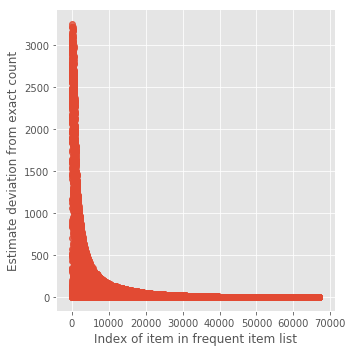

In [20]:
pd_diff3 = diff3.toPandas()
pd_diff3['s_index'] = range(1, len(pd_diff3) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff3, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

In [21]:
experiment4 = df.filter(df['experimentNum'] == 4)
experiment4.createOrReplaceTempView("experiment4")
experiment4 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment4 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment4 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare4 = experiment4.join(gr, experiment4.item == gr.product)
df_compare4.createOrReplaceTempView("df_compare4")
diff4 = spark.sql('SELECT mapSize,item,estimate,lowerBound,upperBound,count, estimate - count as diff, round((100.0*ABS(estimate - count)) / count,3)as diff_percent ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare4 ORDER BY count DESC')
diff4.show()

+-------+----------+--------+----------+----------+-----+----+------------+---------+---------+
|mapSize|      item|estimate|lowerBound|upperBound|count|diff|diff_percent|diffLower|diffUpper|
+-------+----------+--------+----------+----------+-----+----+------------+---------+---------+
|  16384|B0054JZC6E|   25859|     25132|     25859|25368| 491|       1.936|     -236|      491|
|  16384|B00FAPF5U0|   24724|     23990|     24724|24024| 700|       2.914|      -34|      700|
|  16384|B009UX2YAC|   24568|     23843|     24568|23956| 612|       2.555|     -113|      612|
|  16384|0439023483|   21405|     20753|     21405|21398|   7|       0.033|     -645|        7|
|  16384|030758836X|   19870|     19218|     19870|19867|   3|       0.015|     -649|        3|
|  16384|B0051VVOB2|   20012|     19287|     20012|19529| 483|       2.473|     -242|      483|
|  16384|B005SUHPO6|   19156|     18501|     19156|18688| 468|       2.504|     -187|      468|
|  16384|B00G5LQ5MU|   19342|     18617|

In [22]:
diff4.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+------------------+--------------------+-------------------+------------------+
|summary|              diff|        diff_percent|          diffLower|         diffUpper|
+-------+------------------+--------------------+-------------------+------------------+
|  count|            285586|              285586|             285586|            285586|
|   mean|27.851099143515437|25.00176320617957...|-20.844687764806398|27.851099143515437|
| stddev|  82.4387622308031|  32.815717940288586| 63.089935007453754|  82.4387622308031|
|    min|                -2|               0.000|               -735|                -2|
|    max|               735|             100.000|                  0|               735|
+-------+------------------+--------------------+-------------------+------------------+



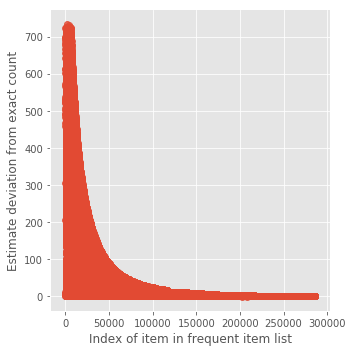

In [23]:
pd_diff4 = diff4.toPandas()
pd_diff4['s_index'] = range(1, len(pd_diff4) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff4, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

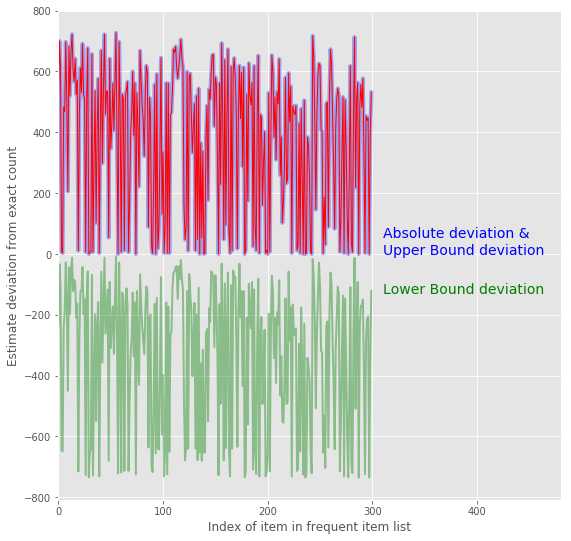

In [33]:
pd_diff4 = diff4.toPandas().head(300)

plt.plot(pd_diff4['diffLower'], marker='', color='green', linewidth=2, alpha=0.4)
plt.plot(pd_diff4['diff'], marker='', color='blue', linewidth=4, alpha=0.3)
plt.plot(pd_diff4['diffUpper'], marker='', color='red', linewidth=1, alpha=1)
plt.xlim(0,480)
plt.text(310,0, 'Absolute deviation &\nUpper Bound deviation', horizontalalignment='left', fontsize=14, color='blue')
plt.text(310,-130, 'Lower Bound deviation', horizontalalignment='left', fontsize=14, color='green')
plt.rcParams["figure.figsize"] =(9,9)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

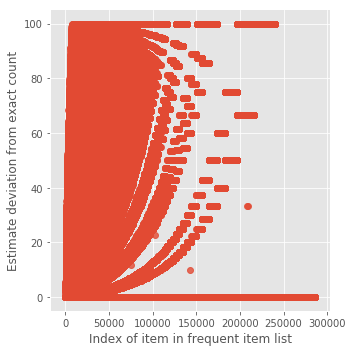

In [25]:
pd_diff4 = diff4.toPandas()
pd_diff4['s_index'] = range(1, len(pd_diff4) + 1)
ax = sns.lmplot( x="s_index", y="diff_percent", data=pd_diff4, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

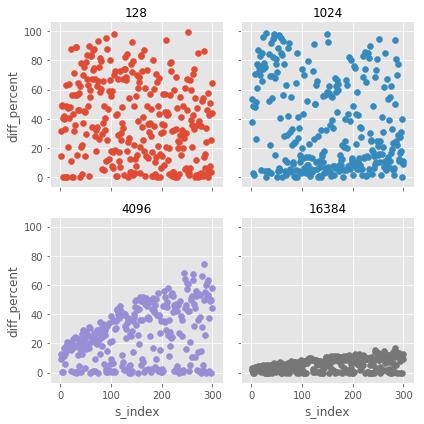

In [26]:
head = 300
frames = [pd_diff1.head(head), pd_diff2.head(head), pd_diff3.head(head),pd_diff4.head(head)]
pd_df = pd.concat(frames, ignore_index=True)
# multiple line plot
# Create a grid : initialize it
g = sns.FacetGrid(pd_df, col='mapSize', hue='mapSize', col_wrap=2, )
 
# Add the line over the area with the plot function
g = g.map(plt.scatter, 's_index' ,'diff_percent')
 
# Fill the area with fill_between
#g = g.map(plt.fill_between, 'years', 'value', alpha=0.2).set_titles("{col_name} country")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
# plt.subplots_adjust(top=0.92)
# g = g.fig.suptitle('Comparison of different map sizes in the Frequent Item Sketch')
 
plt.show()

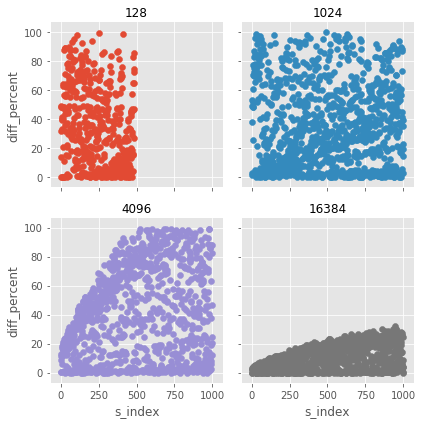

In [27]:
head = 1000
frames = [pd_diff1.head(head), pd_diff2.head(head), pd_diff3.head(head),pd_diff4.head(head)]
pd_df = pd.concat(frames, ignore_index=True)
# multiple line plot
# Create a grid : initialize it
g = sns.FacetGrid(pd_df, col='mapSize', hue='mapSize', col_wrap=2, )
 
# Add the line over the area with the plot function
g = g.map(plt.scatter, 's_index' ,'diff_percent')
 
# Fill the area with fill_between
#g = g.map(plt.fill_between, 'years', 'value', alpha=0.2).set_titles("{col_name} country")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
# plt.subplots_adjust(top=0.92)
# g = g.fig.suptitle('Comparison of different map sizes in the Frequent Item Sketch')
 
plt.show()